# Phase 3: Prior and Simulator Exploration (BayesFlow/SBI)

---

## 1. Introduction

**Goal:**  
For simulation-based inference (SBI) with BayesFlow, you do **not** need to normalize or split your dataset. Instead, you should:
- Ensure your prior and simulator are well-defined and robust.
- Explore and visualize the prior and simulator outputs to check for diversity and realism.

This phase provides pedagogical code and plots for sanity-checking your SBI pipeline.

---

## 2. Why No Normalization or Splitting?

- **BayesFlow** draws parameters from the prior and generates data on-the-fly using the simulator.
- There is no fixed dataset to normalize or split.
- This approach avoids overfitting and ensures the network sees fresh, diverse data during training.

---

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import matplotlib.pyplot as plt
from src.lif_model import lif_simulate
from scipy.stats import uniform

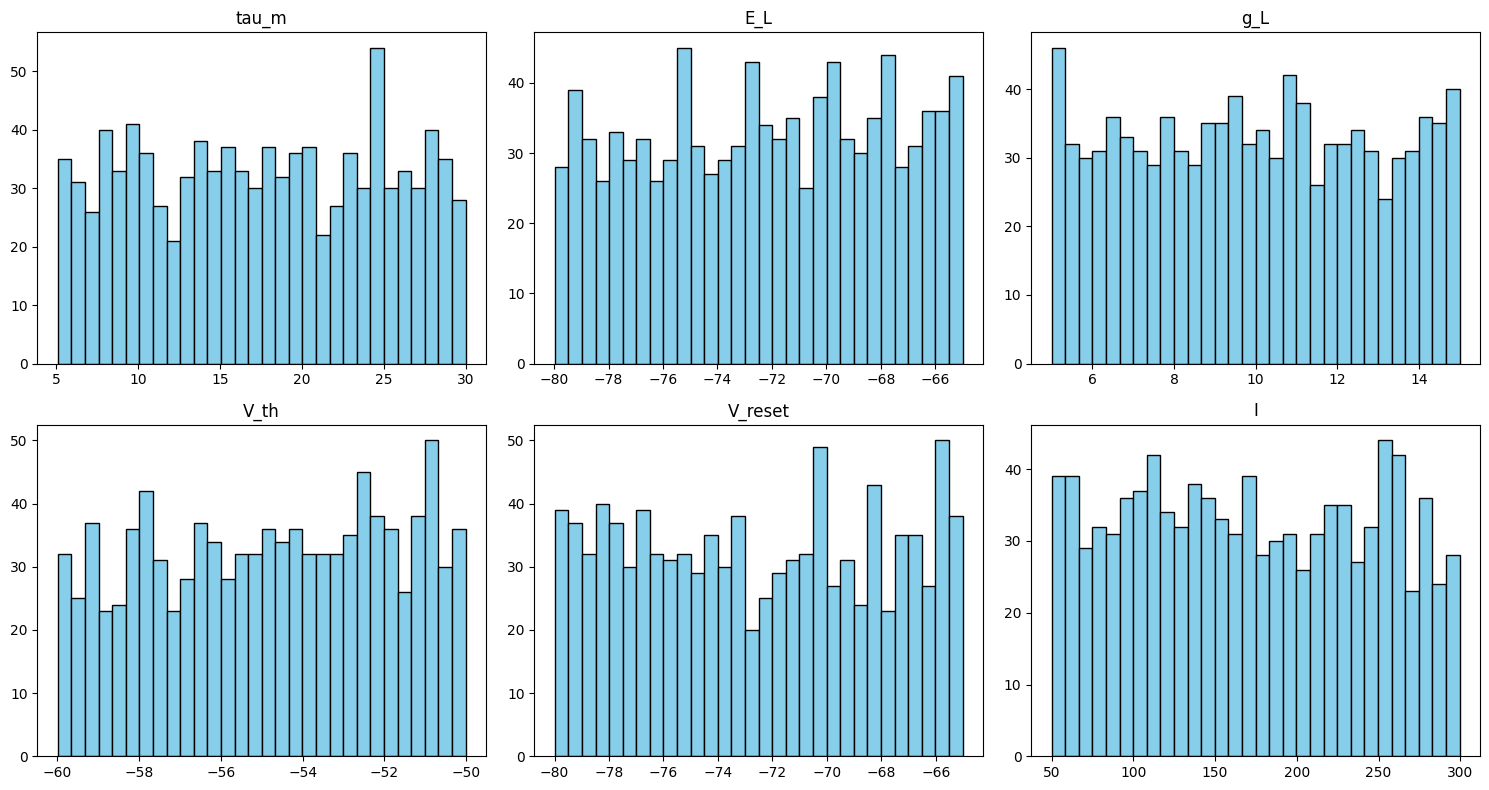

In [2]:
# Define parameter bounds (should match Phase 2)
PARAM_BOUNDS = {
    'tau_m':   (5.0, 30.0),    # ms
    'E_L':     (-80.0, -65.0), # mV
    'g_L':     (5.0, 15.0),    # nS
    'V_th':    (-60.0, -50.0), # mV
    'V_reset': (-80.0, -65.0), # mV
    'I':       (50.0, 300.0),  # pA
}
PARAM_KEYS = list(PARAM_BOUNDS.keys())

# Prior function
def prior(batch_size):
    samples = []
    for key in PARAM_KEYS:
        low, high = PARAM_BOUNDS[key]
        samples.append(uniform.rvs(loc=low, scale=high-low, size=batch_size))
    return np.stack(samples, axis=1)

# Sample from the prior
params = prior(1000)

# Plot histograms
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()
for i, key in enumerate(PARAM_KEYS):
    axes[i].hist(params[:, i], bins=30, color='skyblue', edgecolor='k')
    axes[i].set_title(key)
plt.tight_layout()
plt.show()

## 4. Visualize Simulator Outputs

Let's generate and plot a few example traces to check the diversity and realism of the simulated data.

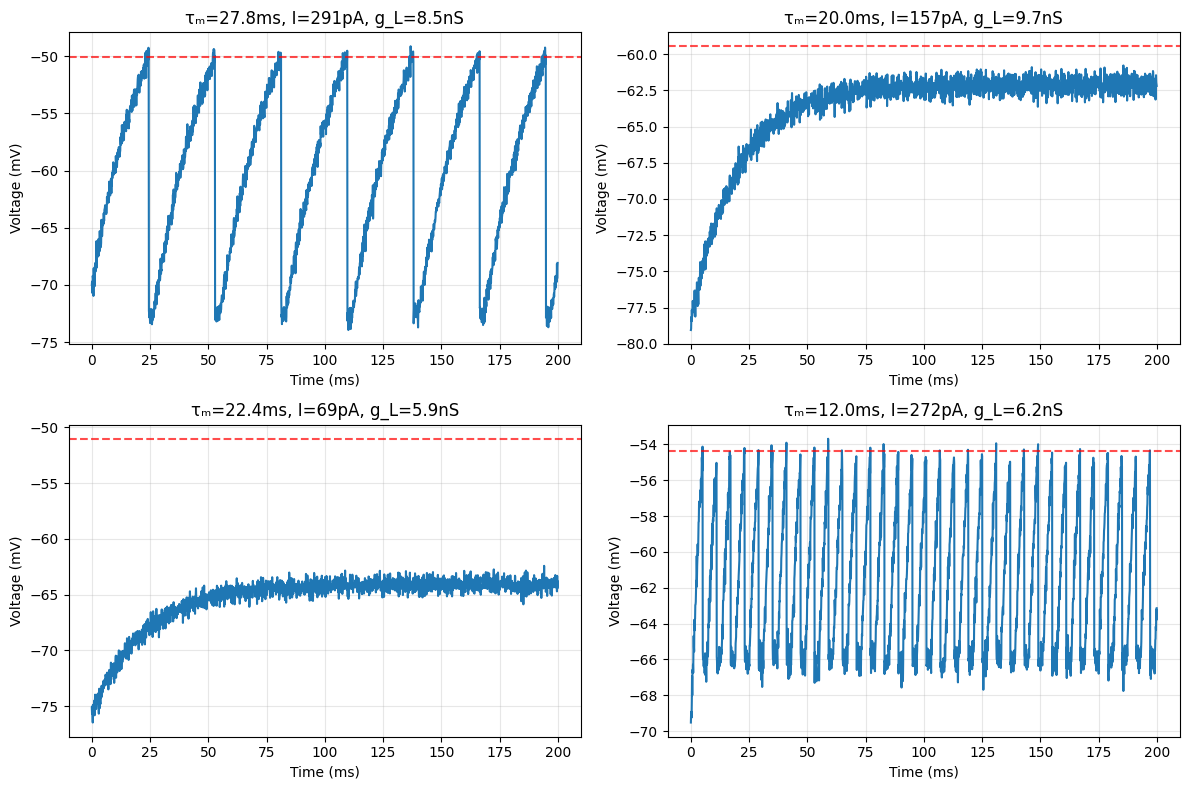

In [3]:
# Simulator function (should match Phase 2)
def simulator(params, T=200.0, dt=0.1, tref=2.0, noise_std=0.5):
    traces = []
    for p in params:
        param_dict = dict(zip(PARAM_KEYS, p))
        sim_args = {
            'T': T,
            'dt': dt,
            'E_L': param_dict['E_L'],
            'V_th': param_dict['V_th'],
            'V_reset': param_dict['V_reset'],
            'tau_m': param_dict['tau_m'],
            'g_L': param_dict['g_L'],
            'I': param_dict['I'],
            'tref': tref
        }
        t, V, spikes = lif_simulate(**sim_args)
        V_noisy = V + np.random.normal(0, noise_std, size=V.shape)
        traces.append(V_noisy)
    return np.stack(traces, axis=0)

# Generate and plot 4 random traces
example_params = prior(4)
traces = simulator(example_params)
t_plot = np.arange(0, traces.shape[1]) * 0.1  # dt=0.1 ms

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
for i in range(4):
    tau_m, E_L, g_L, V_th, V_reset, I = example_params[i]
    axes[i].plot(t_plot, traces[i])
    axes[i].axhline(V_th, color='r', linestyle='--', alpha=0.7)
    axes[i].set_title(f'τₘ={tau_m:.1f}ms, I={I:.0f}pA, g_L={g_L:.1f}nS')
    axes[i].set_xlabel('Time (ms)')
    axes[i].set_ylabel('Voltage (mV)')
    axes[i].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Summary & Next Steps

- No normalization or splitting is needed for BayesFlow/SBI.
- Your prior and simulator are ready for use in neural posterior training (Phase 4).
- Always sanity-check your prior and simulator for coverage and realism before training.

---